In [1]:
from scipy.integrate import odeint
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import lombscargle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
import itertools
from numpy import *
import seaborn as sns
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import os
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import precision_score 
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import warnings
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pycaret

In [117]:
#Function to read the files and separate each AGN and its errors.

def agns(data):
    
    #Read the first column which is the Julian days.
    t = data[:,0]
    
    agn=[] #AGNs
    err_agn=[] #AGNs errors
    star=[] #Calibration Stars
    err_star=[] #Calibration Stars errors
    agn_p=[] #Variable AGNs
    err_agn_p=[] #Variable AGNs errors

    for i in range(1, 544, 2):

        if i <  400: 
 
            agns = data[:,i]
            err_agns = data[:,i+1]
            agn.append(agns)
            err_agn.append(err_agns)
            
        elif i > 400 and i < 526:

            if i == 425:
                control = data[:,i]
                c_error = data[:,i+1]
            else:
                stars = data[:,i]
                err_stars = data[:,i+1]
                star.append(stars)
                err_star.append(err_stars)
            
        elif i > 526: 

            agn_ps = data[:,i]
            err_agn_ps = data[:,i+1]
            agn_p.append(agn_ps)
            err_agn_p.append(err_agn_ps)
            
    return agn, err_agn, star, err_star, agn_p, err_agn_p, t, control
                                       

In [122]:

def calibration(agn, star, err_agn, err_star):

    rest = []
    
    for i in range(62):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude

        cal_star = star[ind_min]

        err_cal = err_agn + err_star[ind_min]#Error calibrated magnitude 
        
    return cal, err_cal, cal_star

In [119]:
def extract_features(mag, mag_w_err):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
        'mag_w_e_mean': np.mean(mag_w_err),
        'mag_w_e_var': np.var(mag_w_err),
        'mag_w_e_skew': skew(mag_w_err),
        'mag_w_e_kurt': kurtosis(mag_w_err),
    }
    
    return features

In [268]:
#Create the dataframe 

def dataframe(df, N, p, star, err_star, c, x, An): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                               # df and star must have the same subindex

    cal_star = []
    D1 = []
    for i in range(N): # N: number of AGNs in the dataset

        if An == 3:
            
            agn_a = agns(df)[c]
            agn = agn_a[i]
    
            err_a = agns(df)[x]
            err_agn = err_a[i]

        else: 

            agn_a = agns_per(df)[c]
            agn = agn_a[i]
    
            err_a = agns_per(df)[x]
            err_agn = err_a[i]

        #Calculates the calibrated magnitude of the AGN
        mag = calibration(agn, star, err_agn, err_star)[0]
        err_mag = calibration(agn, star, err_agn, err_star)[1]
        cal = calibration(agn, star, err_agn, err_star)[2]
        cal_star.append(cal)
        #D1.append(mag)

        
        rng = np.random.default_rng()
        t = rng.uniform(0, 2, N)

        if t[i] <= 1:

            mag_w_err = mag + err_mag

        else:

            mag_w_err = mag - err_mag

        # Extract features from the time series data
        features = extract_features(mag, mag_w_err)

        D1.append(mag_w_err)
        
        # Store the features and the target variable
        data_features.append(features)

        if p == 1:
            variability.append(1)
        else:
            variability.append(0)

    return data_features, D1, cal_star

In [269]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different sintetics curvs 

path = '/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/' #path to main directory
filelist = os.listdir(path)

#Make empty list to store all paths to subdirectories in.
path2 = []
data_features = []
data_features1 = []
variability = []
dlc = []
dlc1 = []
cal = []
cal1 = []
cont = []
cont1 = []


for x in filelist:
    if x.startswith('orig'):
        path2.append(path + x+ '/')
    
    for i in path2:
        filelist2 = os.listdir(i)
        
        for j in filelist2:
            if j.endswith('.dat'):
                dt = np.loadtxt(i+j)
                 
                star = agns(dt)[2]
                err_star = agns(dt)[3]
                
                
                data_features = dataframe(dt, 200, 0, star, err_star, 0, 1, 3)[0]
                data_features1 = dataframe(dt, 9, 1, star, err_star, 4, 5, 3)[0]
                
            

                

                
                # Convert lists to a DataFrame
                features_df = pd.DataFrame(data_features)
                features_df = pd.DataFrame(data_features1)
                features_df['Variability'] = variability   
                
            

            
    path2 = []

In [152]:
features_df

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
0,0.010925,0.000013,-0.040652,-0.912835,0.004800,0.000013,-0.071119,-0.895523,0
1,-0.014825,0.000015,0.046973,-0.469547,-0.021075,0.000016,0.099884,-0.388488,0
2,-0.010350,0.000018,-0.266768,-0.175051,-0.016625,0.000019,-0.178373,-0.274666,0
3,-0.004375,0.000033,-0.210232,0.500604,0.001900,0.000034,-0.014762,0.298399,0
4,0.000800,0.000023,0.429434,0.295149,0.007175,0.000023,0.501832,0.439918,0
...,...,...,...,...,...,...,...,...,...
5220,0.014050,0.012010,0.297835,-1.603264,0.023050,0.011964,0.295835,-1.594466,1
5221,0.007875,0.003598,-0.212056,-1.291822,0.016800,0.003560,-0.201859,-1.280869,1
5222,0.000025,0.001727,0.374140,-0.896395,0.008950,0.001736,0.381997,-0.906512,1
5223,-0.011825,0.001101,-0.246812,-1.147553,-0.002900,0.001096,-0.260810,-1.092889,1


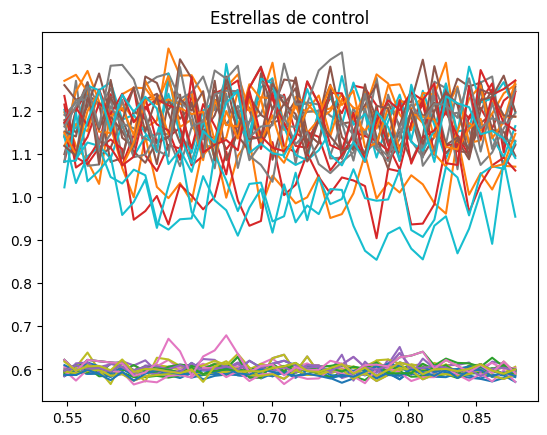

In [270]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different sintetics curvs 

path = '/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/' #path to main directory
filelist = os.listdir(path)

#Make empty list to store all paths to subdirectories in.
path2 = []
data_features = []
data_features1 = []
variability = []
dlc = []
dlc1 = []
cal = []
cal1 = []
cont = []
cont1 = []
p_value = []

for x in filelist:
    if x.startswith('orig'):
        path2.append(path + x+ '/')
    
    for i in path2:
        filelist2 = os.listdir(i)
        
        for j in filelist2:
            if j.endswith('.dat'):
                dt = np.loadtxt(i+j)
                 
                star = agns(dt)[2]
                err_star = agns(dt)[3]
                control_star = agns(dt)[7]
                time = agns(dt)[6]

                
        
                
                D1 = dataframe(dt, 200, 0, star, err_star, 0, 1, 3)[1]
                D1_1 = dataframe(dt, 9, 1, star, err_star, 4, 5, 3)[1]
                
                cal = dataframe(dt, 200, 0, star, err_star, 0, 1, 3)[2]
                cal1 = dataframe(dt, 9, 1, star, err_star, 4, 5, 3)[2]

                D2 = cal -  control_star
                D2_1 = cal1 - control_star

                for i in range (0, 200):
                    
                    # Calculate the sample variances
                    var1 = np.var(D1[i], ddof=1)
                    var2 = np.var(D2[i], ddof=1)
                     
                    # Calculate the F-statistic
                    f_value = var1 / var2
                     
                    # Calculate the degrees of freedom
                    df1 = len(D1[i]) - 1
                    df2 = len(D2[i]) - 1
                     
                    # Calculate the p-value
                    p_v = stats.f.cdf(f_value, df1, df2)

                    p_value.append(p_v)

                    if i == 5:
                    
                        plt.plot(time, abs(D1[i]-D2[i]))
                        plt.title('Estrellas de control')

                for i in range (0, 9):
                    
                    # Calculate the sample variances
                    var1 = np.var(D1_1[i], ddof=1)
                    var2 = np.var(D2_1[i], ddof=1)
                     
                    # Calculate the F-statistic
                    f_value = var1 / var2
                     
                    # Calculate the degrees of freedom
                    df1 = len(D1_1[i]) - 1
                    df2 = len(D2_1[i]) - 1
                     
                    # Calculate the p-value
                    p_v = stats.f.cdf(f_value, df1, df2)

                    p_value.append(p_v)
                    
                    if i == 5:
                    
                        plt.plot(time, abs(D1_1[i]-D2_1[i]))
                        plt.title('Estrellas de control')
                                  
                # Convert lists to a DataFrame   
                fisher = pd.DataFrame(p_value)
                fisher['p_value'] = pd.DataFrame(p_value)
               
    path2 = []

In [271]:
fisher

,0,p_value
0,0.331531,0.331531
1,0.287770,0.287770
2,0.526002,0.526002
3,0.966138,0.966138
4,0.740788,0.740788
...,...,...
5220,1.000000,1.000000
5221,1.000000,1.000000
5222,1.000000,1.000000
5223,1.000000,1.000000


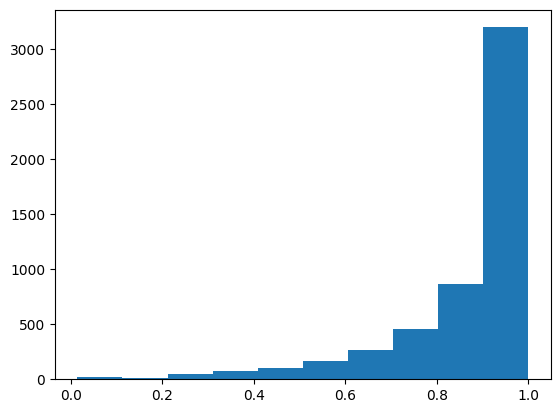

In [272]:
plt.hist(fisher.p_value, bins=10);

In [273]:
test = features_df[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
var = features_df['Variability']

In [274]:
fisher['variabilidad'] = var

filtro = fisher[fisher.p_value <0.1]

filtro

,0,p_value,variabilidad
464,0.031468,0.031468,0
819,0.083835,0.083835,0
849,0.015330,0.015330,0
1058,0.015330,0.015330,0
1271,0.014324,0.014324,0
1689,0.014324,0.014324,0
2491,0.083835,0.083835,0
2957,0.050185,0.050185,0
3611,0.069922,0.069922,0
4017,0.031468,0.031468,0


In [261]:
import pandas as pd
from joblib import load

model= load('agn_variability_class')

In [262]:
model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['mag_mean', 'mag_var', 'mag_skew',
                                             'mag_kurt'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('balance',
                 TransformerWrapper(transformer=FixImbalancer(estimator=SMOTE()))...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None, min_child_weight=4,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=150, n_jobs=-1,
                               num_parallel_tree=None, random_state=746, ...))])

In [281]:
pred = model.predict(test)


In [282]:
pred = pd.DataFrame(pred)
pred['Prediccion'] = pd.DataFrame(pred)

pred ['variabilidad'] = var
pred

,0,Prediccion,variabilidad
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
5220,1,1,1
5221,1,1,1
5222,1,1,1
5223,1,1,1


In [289]:
filtro1 = pred[pred.Prediccion == 1]
filtro3 = pred[pred.Prediccion == 0]
filtro1



,0,Prediccion,variabilidad
200,1,1,1
201,1,1,1
202,1,1,1
203,1,1,1
204,1,1,1
...,...,...,...
5220,1,1,1
5221,1,1,1
5222,1,1,1
5223,1,1,1


In [288]:
filtro2 = filtro1[filtro1.variabilidad == 0]
filtro2

,0,Prediccion,variabilidad
1598,1,1,0
1633,1,1,0
3030,1,1,0
3921,1,1,0
4892,1,1,0


In [292]:
filtro4 = filtro3[filtro3.variabilidad == 1]
filtro4

,0,Prediccion,variabilidad
